In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
# sys.path.append(os.path.join(project_root, 'code'))
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils
from behav_analysis import analyze_expt1

In [5]:
super_names, super_cbinds, basic_names, basic_inds, \
        super_names_long, super_inds_long, n_basic, n_super, n_basic_each_super = \
            analyze_expt1.get_categ_info()

trial_data_all, subjects, subject_cb, cue_level_names, image_type_names = analyze_expt1.load_data()
 
n_subjects = len(subjects)
n_cue_levels = len(cue_level_names)
n_image_types = len(image_type_names)

acc_by_condition, dprime_by_condition, propyes_by_condition, rt_by_condition = analyze_expt1.get_perf_by_cond()

acc_by_run, rt_by_run = analyze_expt1.get_perf_by_run()

acc_by_nat, dprime_by_nat, propyes_by_nat, rt_by_nat = analyze_expt1.get_perf_by_nat()

acc_by_supcat, dprime_by_supcat, rt_by_supcat = analyze_expt1.get_perf_by_supercateg()


In [9]:
super_names, super_cbinds

(array(['bird', 'body_part', 'drink', 'electronic_device', 'fruit',
        'home_decor', 'medical_equipment', 'sports_equipment', 'vehicle',
        'weapon', 'clothing', 'dessert', 'furniture', 'insect',
        'kitchen_tool', 'office_supply', 'part_of_car', 'plant', 'toy',
        'vegetable'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [8]:
dprime_by_supcat[1].shape

(23, 2, 5, 10)

In [116]:
subjects, subject_cb

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0]))

In [37]:
cue_level_names = ['Fine','Coarse']

Text(0.5, 1.0, 'Response Time\n(n=45)')

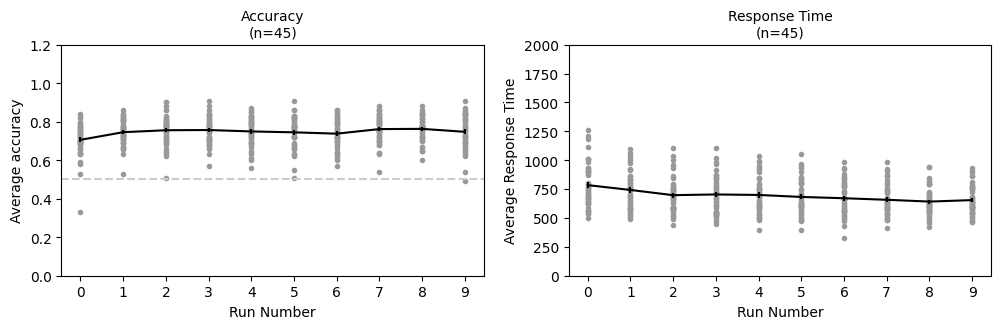

In [60]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plot_vals = acc_by_run

n_runs = plot_vals.shape[1]
meanvals = np.mean(plot_vals, axis=0)
semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

for si in range(n_subjects):
    plt.plot(np.arange(n_runs), plot_vals[si,:],'.',color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, color='k')
plt.xticks(np.arange(n_runs))
plt.xlabel('Run Number')
plt.ylabel('Average accuracy')
plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
plt.ylim([0.0, 1.2])

plt.title('Accuracy\n(n=%d)'%n_subjects)


plt.subplot(1,2,2)

plot_vals = rt_by_run

meanvals = np.mean(plot_vals, axis=0)
semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

for si in range(n_subjects):
    plt.plot(np.arange(n_runs), plot_vals[si,:],'.',color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, color='k')
plt.xticks(np.arange(n_runs))
plt.xlabel('Run Number')
plt.ylabel('Average Response Time')
ylims = [0, 2000]
plt.ylim(ylims)

plt.title('Response Time\n(n=%d)'%n_subjects)

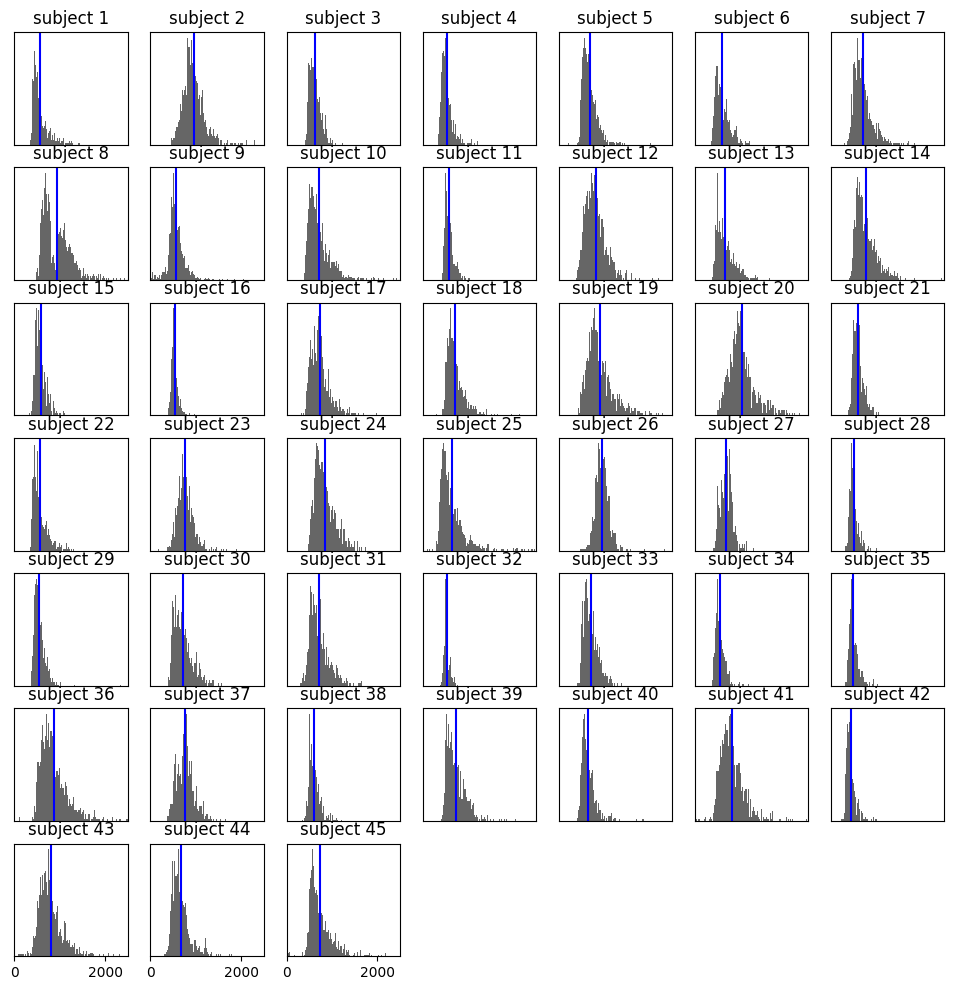

In [4]:
plt.figure(figsize=(12,12))
npy = int(np.ceil(np.sqrt(n_subjects)))
npx = int(np.ceil(n_subjects/npy))
xlims = [0, 500 + 2000]

for si,ss in enumerate(subjects):

    plt.subplot(npx, npy, si+1)
    
    rts = np.array(trial_data_all['rt'])[trial_data_all['subject']==ss]
    
    rts = rts[~np.isnan(rts)]
    
    assert(np.all(rts<=2500))
    
    plt.hist(rts,100, color=[0.4, 0.4, 0.4]);
    
    plt.title('subject %d'%ss)
    
    plt.xlim(xlims)
    if si<((npx-1)*(npy)):
        plt.xticks([])
    plt.yticks([])
    
    plt.axvline(np.mean(rts), color='b')

#### Plotting params

In [13]:
cue_level_colors = np.array([[130, 181, 216], [44,92,168]])/255
point_types = ['o','x']
markersize = 4;
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

#### Run stats on the d' values (combine all subjects/all image sets)

In [184]:
vals = dprime_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)

# then pairwise t-tests (fine vs coarse)
result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
tvals = result.statistic
pvals = result.pvalue

df = pd.DataFrame(index=image_type_names)
df['t (basic-super)'] = tvals.round(4)
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df


All subjects:
(45, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond             148.383622     1.0    44.0  1.085526e-15
image_type       303.629878     4.0   176.0  7.885969e-78
cond:image_type    6.080447     4.0   176.0  1.320202e-04


,t (basic-super),p
pool1,-2.8811,6.103408e-03
pool2,-8.8764,1.154249e-10
pool3,-7.7002,1.818611e-09
pool4,-8.3506,3.181276e-10
orig,-3.7630,6.165633e-04


#### Plot d' values

Text(0.5, 1.0, 'All subjects (n=45)')

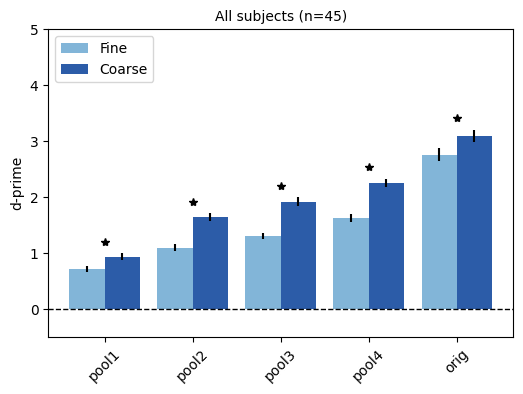

In [185]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = dprime_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)


plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

plt.ylim([-.5, 5.0])
# assert(np.all(vals<5.0))
# assert(np.all(vals>-0.5))

ax.legend(lh, cue_level_names, loc='upper left')

plt.ylabel('d-prime')

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### Check if d' is above chance for each condition

In [188]:
result = scipy.stats.ttest_1samp(dprime_by_condition, popmean = 0, axis=0, alternative = 'greater')
tvals = result.statistic
pvals = result.pvalue
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
print(tvals)
np.all(pvals_fdr<0.01)

[[14.01812457 18.17770753 22.9888912  22.45560848 24.25089139]
 [15.18926115 22.22359592 24.9564482  28.32643522 28.32602062]]


True

#### pairwise comparisons across image types

In [159]:
pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)

# averaging across basic/super conds here
vals = np.mean(dprime_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    result = scipy.stats.ttest_rel(vals1, vals2, axis=0, alternative='two-sided')
    t = result.statistic
    p = result.pvalue
    # p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, n_iter=10000, rndseed=123434+pi)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr

df   

,t,p
pool1 vs pool2,-8.5415,8.530690e-11
pool1 vs pool3,-15.9049,1.473735e-19
pool1 vs pool4,-20.6652,1.398143e-23
pool1 vs orig,-25.8885,2.901677e-27
pool2 vs pool3,-4.1221,1.634887e-04
pool2 vs pool4,-10.2017,5.137003e-13
pool2 vs orig,-19.9522,3.776601e-23
pool3 vs pool4,-7.6369,1.497583e-09
pool3 vs orig,-17.1248,1.110103e-20
pool4 vs orig,-15.7905,1.610884e-19


#### Analyze d' values: separating out the two image sets

In [189]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = dprime_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)

    result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
    tvals[cbi,:] = result.statistic
    pvals[cbi,:] = result.pvalue
    
    # for ii in range(n_image_types):
        
    #     p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii], n_iter=10000, rndseed=566566+ii)
        
    #     tvals[cbi, ii] = t
    #     pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(22, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond              51.173314     1.0    21.0  4.712152e-07
image_type       226.257294     4.0    84.0  4.138148e-44
cond:image_type    4.368376     4.0    84.0  2.940626e-03

Image set 2:
(23, 2, 5)
                    F Value  Num DF  Den DF        Pr > F
cond             116.578169     1.0    22.0  2.937546e-10
image_type       156.900128     4.0    88.0  3.542465e-39
cond:image_type    8.231875     4.0    88.0  1.095056e-05

Image set 1:
(22, 2, 5)

Image set 2:
(23, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-0.8281,0.416924,-3.7990,0.001229
pool2,-6.1591,0.000010,-6.8222,0.000004
pool3,-5.1631,0.000082,-6.2133,0.000010
pool4,-4.8081,0.000157,-7.1980,0.000003
orig,-4.4421,0.000323,-0.9485,0.392412


#### Plot d' values, each image set

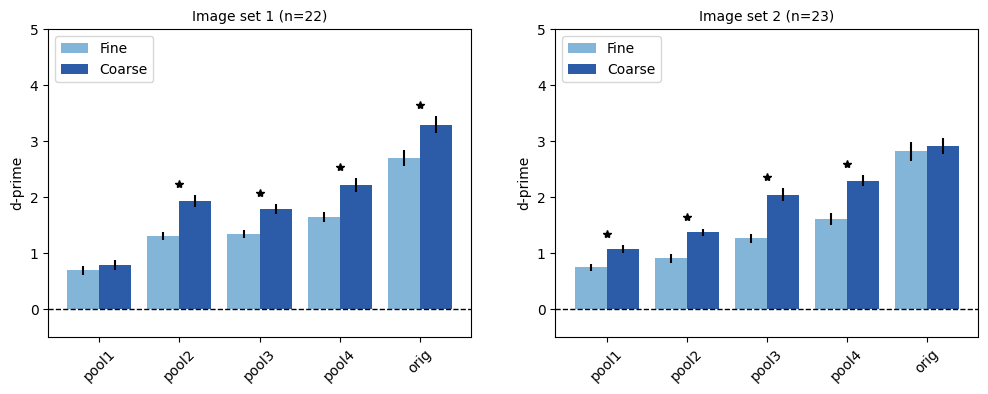

In [190]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals_fdr[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.20
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
    plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

    ax.legend(lh, cue_level_names, loc='upper left')
    
    plt.ylabel('d-prime')
    
    plt.ylim([-.5, 5.0])
    assert(np.all(vals<5.0))
    assert(np.all(vals>-0.5))
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Check if all d' values are above chance

In [191]:
for cbi, cb in enumerate([1,2]):
    
    vals = dprime_by_condition[subject_cb==cbi,:,:]
        
    result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
    tvals = result.statistic
    pvals = result.pvalue
    _, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

    print('Set %d (n=%d)'%(cb, vals.shape[0]))
    print(tvals)
    print(np.all(pvals_fdr<0.01))

Set 1 (n=22)
[[ 8.85249408 18.35121902 17.34139097 17.80307555 17.82451322]
 [ 8.497015   18.22518121 20.59147342 17.37489107 21.01427309]]
True
Set 2 (n=23)
[[10.91870631 11.42347232 15.16100927 14.27556967 16.43910452]
 [14.88176841 20.84149103 16.83424472 23.14007642 19.96544613]]
True


#### Analyze RTs

In [161]:
vals = rt_by_condition

print('\nAll subjects:')
print(vals.shape)

aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

print(aov_table)

# then pairwise t-tests (fine vs coarse)
result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
t = result.statistic
p = result.pvalue

df = pd.DataFrame(index=image_type_names)
df['t (basic-super)'] = t.round(4)
_, pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr
df


All subjects:
(45, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              0.636505     1.0    44.0  4.292639e-01
image_type       21.226799     4.0   176.0  2.668022e-14
cond:image_type   6.380723     4.0   176.0  8.109120e-05


,t (basic-super),p
pool1,-2.9973,0.022328
pool2,-0.3993,0.691631
pool3,0.4650,0.691631
pool4,2.1778,0.087068
orig,-1.5343,0.220211


In [152]:
p, pvals_fdr

(array([0.00446569, 0.69163086, 0.64425803, 0.03482731, 0.13212657]),
 array([0.02232847, 0.69163086, 0.69163086, 0.08706827, 0.22021094]))

#### plot RTs, all subjects

Text(0.5, 1.0, 'All subjects (n=45)')

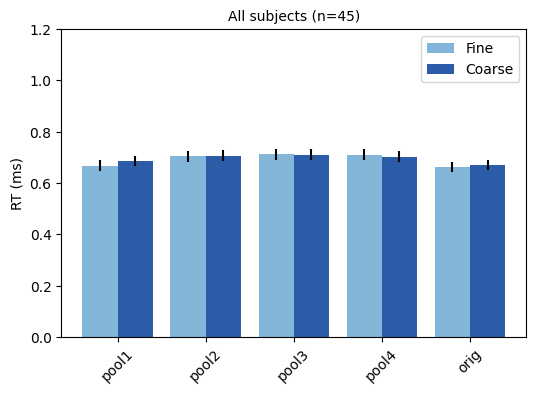

In [153]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = rt_by_condition/1000

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    if pvals_fdr[ii]<0.01:
        height = np.max(meanvals[:,ii]+semvals[:,ii])+0.05
        plt.plot(ii, height, '*', color='k')

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

# plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('RT (ms)')

plt.ylim([0, 1.200])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### pairwise comparisons across image types

In [162]:

pairs_test = list(itertools.combinations(np.arange(5),2))
n_pairs = len(pairs_test)
pair_names = ['%s vs %s'%(image_type_names[ii], image_type_names[jj]) for ii, jj in pairs_test]

tvals = np.zeros((n_pairs))
pvals = np.zeros((n_pairs))

df = pd.DataFrame(index=pair_names)


# averaging across basic/super conds here
vals = np.mean(rt_by_condition, axis=1)

for pi, pair in enumerate(pairs_test):

    vals1 = vals[:,pair[0]]
    vals2 = vals[:,pair[1]]

    result = scipy.stats.ttest_rel(vals1, vals2, axis=0, alternative='two-sided')
    t = result.statistic
    p = result.pvalue
    # p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, n_iter=10000, rndseed=132433+pi)

    tvals[pi] = t
    pvals[pi] = p

df['t'] = tvals.round(4)

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')
df['p'] = pvals_fdr


df   

,t,p
pool1 vs pool2,-6.3606,4.687940e-07
pool1 vs pool3,-5.9694,9.358123e-07
pool1 vs pool4,-4.2519,1.811959e-04
pool1 vs orig,0.9078,4.099367e-01
pool2 vs pool3,-2.1127,5.761980e-02
pool2 vs pool4,-0.3522,7.263456e-01
pool2 vs orig,4.7530,4.340828e-05
pool3 vs pool4,1.6380,1.357014e-01
pool3 vs orig,6.2585,4.687940e-07
pool4 vs orig,7.0275,1.041743e-07


#### RTs: separate out the two image sets

In [163]:
for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)
    
    aov_table = stats_utils.rmanova_2way(vals, ['cond','image_type'])

    print(aov_table)


tvals = np.zeros((2,5))
pvals = np.zeros((2,5))

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):
    
    subjects_plot = (subject_cb==cbi) 
    n_subs_plot = np.sum(subjects_plot)
    
    vals = rt_by_condition[subjects_plot,:,:]
    
    print('\nImage set %d:'%cb)
    print(vals.shape)

    result = scipy.stats.ttest_rel(vals[:,0,:], vals[:,1,:], axis=0, alternative='two-sided')
    tvals[cbi,:] = result.statistic
    pvals[cbi,:] = result.pvalue
    
    # for ii in range(n_image_types):
        
    #     p, t = stats_utils.paired_ttest_nonpar(vals[:,0,ii], vals[:,1,ii], n_iter=10000, rndseed=566566+ii)
        
    #     tvals[cbi, ii] = t
    #     pvals[cbi, ii] = p
        
# fdr correcting all the values together
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cbi, cb in enumerate([1,2]):
    
    df['Set %d: t'%cb] = tvals[cbi,:].round(4)
    df['Set %d: p'%cb] = pvals_fdr[cbi,:]
    

df


Image set 1:
(22, 2, 5)
                   F Value  Num DF  Den DF        Pr > F
cond              0.878800     1.0    21.0  3.591878e-01
image_type       12.960402     4.0    84.0  2.907572e-08
cond:image_type   5.706534     4.0    84.0  4.113011e-04

Image set 2:
(23, 2, 5)
                  F Value  Num DF  Den DF    Pr > F
cond             0.034225     1.0    22.0  0.854924
image_type       8.833929     4.0    88.0  0.000005
cond:image_type  1.498526     4.0    88.0  0.209542

Image set 1:
(22, 2, 5)

Image set 2:
(23, 2, 5)


,Set 1: t,Set 1: p,Set 2: t,Set 2: p
pool1,-3.9231,0.007806,-1.0937,0.571812
pool2,-0.6092,0.784166,0.0766,0.939660
pool3,0.4324,0.837360,0.2153,0.923870
pool4,1.5469,0.477177,1.5184,0.477177
orig,-1.2799,0.536329,-0.8390,0.684178


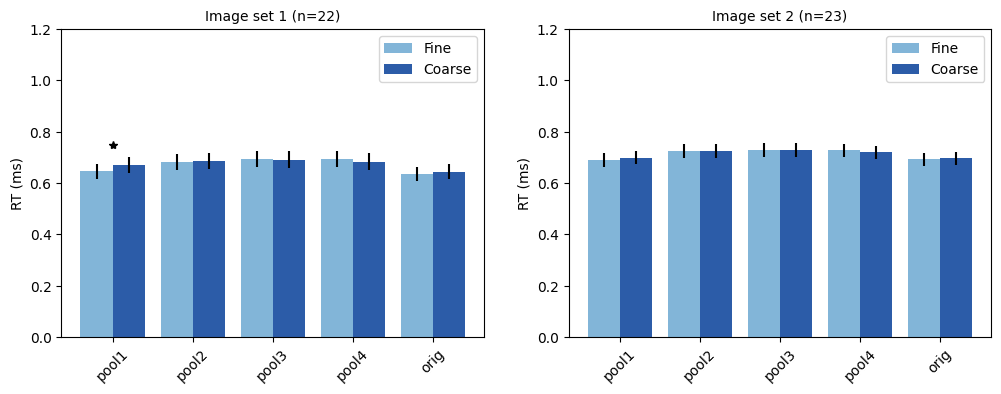

In [164]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(12,4))
    
for cbi, cb in enumerate([1,2]):

    ax = plt.subplot(1,2,cb)
    
    vals = rt_by_condition[subject_cb==cbi,:,:] / 1000
    
    n_subs_plot = vals.shape[0]
        
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
    
    lh = []
    
    for ii in range(n_image_types):
        
        for cc, cue in enumerate(cue_level_names):
        
            h = plt.bar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                            color = cue_level_colors[cc,:], width=barwidth)
            
            plt.errorbar(ii+xjitters[cc], \
                             meanvals[cc,ii], \
                             semvals[cc,ii], \
                            color = 'k',
                            linestyle='none')
        
            lh.append(h)
    
        if pvals_fdr[cbi, ii]<0.01:
            height = np.max(meanvals[:,ii]+semvals[:,ii])+0.05
            plt.plot(ii, height, '*', color='k')
    
        
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)
    
        
        
    
    # plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')
    
    ax.legend(lh, cue_level_names, loc='upper right')
    
    plt.ylabel('RT (ms)')
    
    plt.ylim([0, 1.200])
    
    plt.title('Image set %d (n=%d)'%(cb, n_subs_plot))

#### Response bias

Text(0.5, 1.0, 'All subjects (n=45)')

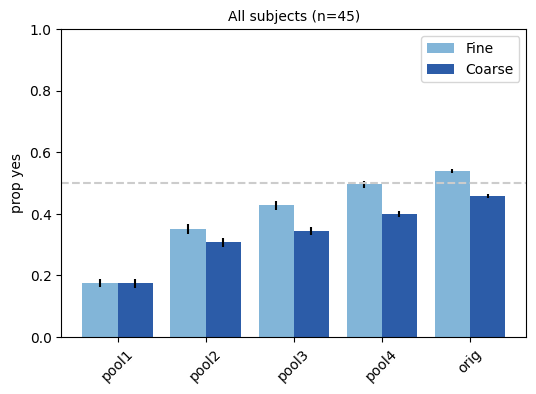

In [165]:
plot_utils.set_all_font_sizes(10)
plt.figure(figsize=(6,4))

vals = propyes_by_condition

n_subs_plot = vals.shape[0]
    
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)
  
ax = plt.subplot(1,1,1)


lh = []

for ii in range(n_image_types):
    
    for cc, cue in enumerate(cue_level_names):
    
        h = plt.bar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                        color = cue_level_colors[cc,:], width=barwidth)
        
        plt.errorbar(ii+xjitters[cc], \
                         meanvals[cc,ii], \
                         semvals[cc,ii], \
                        color = 'k',
                        linestyle='none')
    
        lh.append(h)

    
plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)

    
    

plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

ax.legend(lh, cue_level_names, loc='upper right')

plt.ylabel('prop yes')

plt.ylim([0, 1.0])

plt.title('All subjects (n=%d)'%(n_subs_plot))

#### Natural versus artificial

In [39]:
tvals = np.zeros((n_image_types, n_cue_levels))
pvals = np.zeros((n_image_types, n_cue_levels))

vals = dprime_by_nat;

df = pd.DataFrame(index=image_type_names)

result = scipy.stats.ttest_rel(vals[:,:,:,0], vals[:,:,:,1], axis=0, alternative='two-sided')
# want [image types x cue levels]
tvals[:,:] = result.statistic.T
pvals[:,:] = result.pvalue.T

_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cc, cue in enumerate(cue_level_names):

    df['%s: t'%(cue_level_names[cc])] = tvals[:,cc].round(4)

    df['%s: p'%(cue_level_names[cc])] = pvals_fdr[:,cc]

# print(df)
df

,Fine: t,Fine: p,Coarse: t,Coarse: p
pool1,-2.3025,3.262376e-02,-7.5055,6.966950e-09
pool2,-3.5869,1.193226e-03,-5.3909,4.377614e-06
pool3,-6.9431,3.463651e-08,-10.8294,5.406512e-13
pool4,-1.7751,8.280314e-02,-8.2270,9.543269e-10
orig,2.1929,3.738036e-02,-6.2652,2.749542e-07


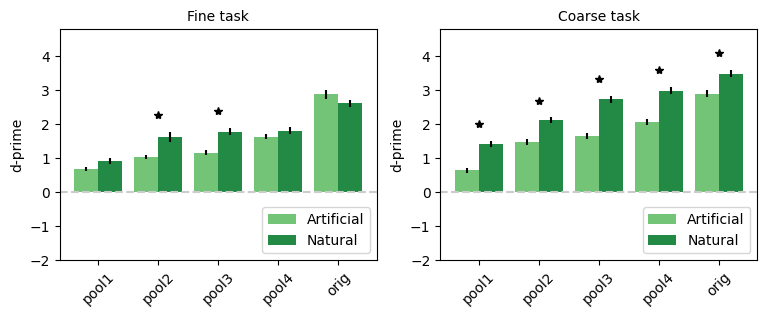

In [40]:
plot_utils.set_all_font_sizes(10)


nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]
n_kinds = 2
kind_names = ['Artificial','Natural']

plt.figure(figsize=(9,3))

    
for cc in [0,1]:
    
    ax = plt.subplot(1,2,cc+1)

    vals = dprime_by_nat[:,cc,:,:]
    n_subs_plot = vals.shape[0]

    plot_vals = vals;
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

    lh = []
    
    for kk in range(n_kinds):

        # for si in range(n_subs_plot):

        h = plt.bar(np.arange(n_image_types)+xjitters[kk], \
                 meanvals[:,kk], color=nat_colors[kk,:], width=barwidth)
        
        plt.errorbar(np.arange(n_image_types)+xjitters[kk], \
                                 meanvals[:,kk], \
                                 semvals[:,kk], \
                                color = 'k', linestyle='none')
        lh.append(h)

    for ii in range(n_image_types):
        if pvals_fdr[ii,cc]<0.01:
            height = np.max(meanvals[ii,:]+semvals[ii,:])+0.50
            plt.plot(ii, height, '*', color='k')

    
    # plt.title('image set %d'%(cb))
    
    plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)


    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, kind_names, loc='lower right')

    plt.ylabel('d-prime')

    plt.ylim([-2, 4.8])
        
    plt.title('%s task'%(cue_level_names[cc]))

In [41]:
vals = dprime_by_nat
dim_names = ['cond','image_type','naturalness']
stats_utils.rmanova_3way(vals, dim_names)

,F Value,Num DF,Den DF,Pr > F
cond,192.313307,1.0,44.0,1.147016e-17
image_type,320.585895,4.0,176.0,1.201300e-79
naturalness,207.612737,1.0,44.0,2.866470e-18
cond:image_type,10.979492,4.0,176.0,5.689462e-08
cond:naturalness,33.501050,1.0,44.0,6.908946e-07
image_type:naturalness,12.934835,4.0,176.0,2.969124e-09
cond:image_type:naturalness,3.636997,4.0,176.0,7.116582e-03


#### Natural versus artificial: within image set

In [173]:
tvals = np.zeros((n_image_types, n_cue_levels, 2))
pvals = np.zeros((n_image_types, n_cue_levels, 2))

dvals = dprime_by_nat;

df = pd.DataFrame(index=image_type_names)

for cbi, cb in enumerate([1,2]):

    subjects_plot = (subject_cb==cbi) 

    vals = dvals[subjects_plot,:,:,:]

    result = scipy.stats.ttest_rel(vals[:,:,:,0], vals[:,:,:,1], axis=0, alternative='two-sided')
    # want [image types x cue levels]
    tvals[:,:,cbi] = result.statistic.T
    pvals[:,:,cbi] = result.pvalue.T
  
_, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

for cc, cue in enumerate(cue_level_names):

    for cbi, cb in enumerate([1,2]):
    
        df['Set %d, %s: t'%(cb,cue_level_names[cc])] = tvals[:,cc,cbi].round(4)
    
        df['Set %d, %s: p'%(cb,cue_level_names[cc])] = pvals_fdr[:,cc,cbi]

# print(df)
df

,"Set 1, Fine: t","Set 1, Fine: p","Set 2, Fine: t","Set 2, Fine: p","Set 1, Coarse: t","Set 1, Coarse: p","Set 2, Coarse: t","Set 2, Coarse: p"
pool1,-2.7253,1.810902e-02,-0.7287,0.498790,-4.8340,1.902181e-04,-6.0020,1.617007e-05
pool2,-13.5423,1.518772e-10,3.2208,0.006053,-1.2162,2.637905e-01,-7.9263,4.587417e-07
pool3,-4.7649,1.902181e-04,-4.9413,0.000152,-10.0183,1.876464e-08,-6.2136,1.187807e-05
pool4,-2.1466,5.822059e-02,-0.4094,0.686192,-7.2428,1.951470e-06,-4.7317,1.902181e-04
orig,1.6141,1.517987e-01,1.4892,0.177199,-3.7244,2.088626e-03,-5.1597,1.023336e-04


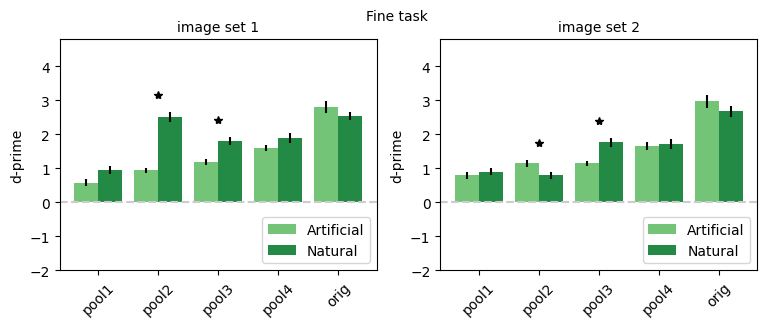

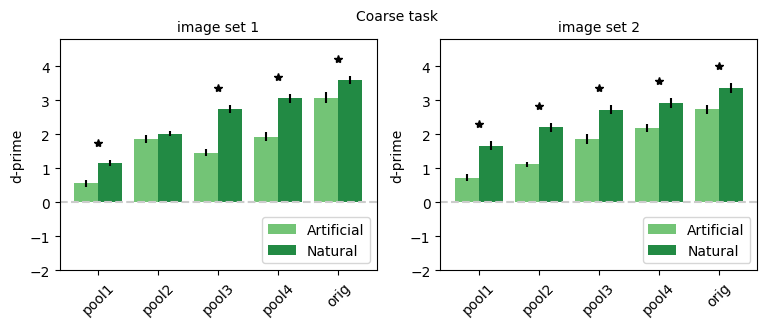

In [174]:
plot_utils.set_all_font_sizes(10)


nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]
n_kinds = 2
kind_names = ['Artificial','Natural']

for cc in [0,1]:
    
    plt.figure(figsize=(9,3))

    for cbi, cb in enumerate([1,2]):
    
        ax = plt.subplot(1,2,cb)
        
        subjects_plot = (subject_cb==cbi) 
        n_subs_plot = np.sum(subjects_plot)
        vals = dprime_by_nat[subjects_plot,cc,:,:]
        
        plot_vals = vals;
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        lh = []
        
        for kk in range(n_kinds):

            # for si in range(n_subs_plot):

            h = plt.bar(np.arange(n_image_types)+xjitters[kk], \
                     meanvals[:,kk], color=nat_colors[kk,:], width=barwidth)
            
            plt.errorbar(np.arange(n_image_types)+xjitters[kk], \
                                     meanvals[:,kk], \
                                     semvals[:,kk], \
                                    color = 'k', linestyle='none')
            lh.append(h)

        for ii in range(n_image_types):
            if pvals_fdr[ii,cc,cbi]<0.01:
                height = np.max(meanvals[ii,:]+semvals[ii,:])+0.50
                plt.plot(ii, height, '*', color='k')

        
        plt.title('image set %d'%(cb))
        
        plt.xticks(np.arange(n_image_types), image_type_names, rotation=45)


        plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

        ax.legend(lh, kind_names, loc='lower right')

        plt.ylabel('d-prime')

        plt.ylim([-2, 4.8])
        
    plt.suptitle('%s task'%(cue_level_names[cc]))

#### Check if all d' values are above chance

In [192]:
for cbi, cb in enumerate([1,2]):
    
    vals = dprime_by_nat[subject_cb==cbi,:,:]
        
    result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
    tvals = result.statistic
    pvals = result.pvalue
    _, pvals_fdr = stats_utils.fdr_keepshape(pvals, alpha=0.01, method='poscorr')

    print('Set %d (n=%d)'%(cb, vals.shape[0]))
    print(tvals)
    print(np.all(pvals_fdr<0.01))

Set 1 (n=22)
[[[ 6.13886122  7.86146292]
  [13.34144581 17.48635102]
  [13.29188044 14.07492441]
  [18.56918924 12.20741278]
  [16.13370988 20.20267167]]

 [[ 5.21436633 12.2563658 ]
  [14.98616582 23.31788528]
  [14.37235655 22.80702933]
  [13.74419817 23.13125163]
  [18.91645439 29.64889266]]]
True
Set 2 (n=23)
[[[ 7.75284751  8.25451358]
  [12.19050749  7.69742002]
  [12.83567957 12.58536457]
  [13.21168495 11.55232749]
  [14.81105252 15.94156998]]

 [[ 6.67661648 12.86767621]
  [15.71925554 16.18562527]
  [12.91977628 18.87315966]
  [17.94258785 19.88499996]
  [19.94429612 20.38419962]]]
True


In [193]:
dprime_by_nat.shape

(45, 2, 5, 2)

In [11]:
dprime_by_supcat[0].shape

(22, 2, 5, 10)

#### Analyze individual super-categories

In [30]:
allp = []
for cbi, cb in enumerate([1,2]):
        
    vals = dprime_by_supcat[cbi]

    supnames = super_names[super_cbinds==cbi]
    
    result = scipy.stats.ttest_1samp(vals, popmean = 0, axis=0, alternative = 'greater')
    tvals = result.statistic
    pvals = result.pvalue

    allp += [pvals]

# allp = np.array(allp)
allp = np.concatenate(allp, axis=2)

_, pvals_fdr = stats_utils.fdr_keepshape(allp, alpha=0.01, method='poscorr')
    
print(np.all(pvals_fdr<0.01))
    

False


In [31]:
super_names, super_cbinds

(array(['bird', 'body_part', 'drink', 'electronic_device', 'fruit',
        'home_decor', 'medical_equipment', 'sports_equipment', 'vehicle',
        'weapon', 'clothing', 'dessert', 'furniture', 'insect',
        'kitchen_tool', 'office_supply', 'part_of_car', 'plant', 'toy',
        'vegetable'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

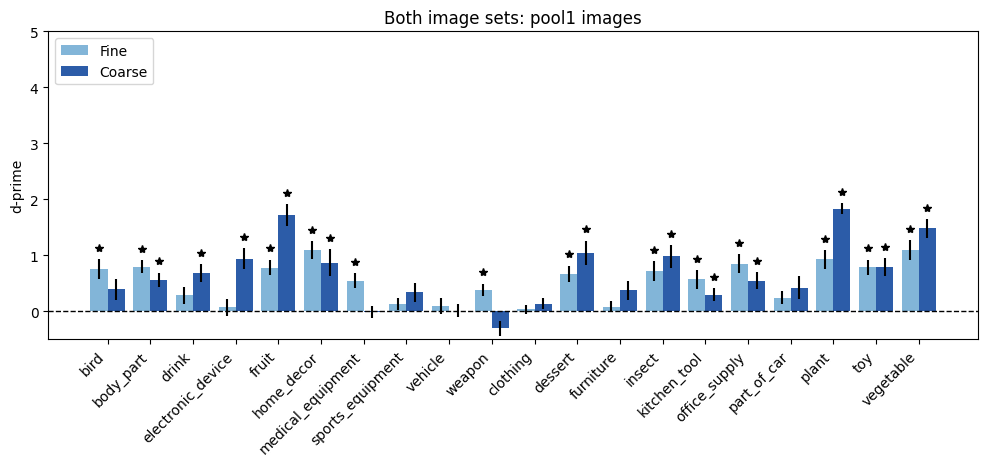

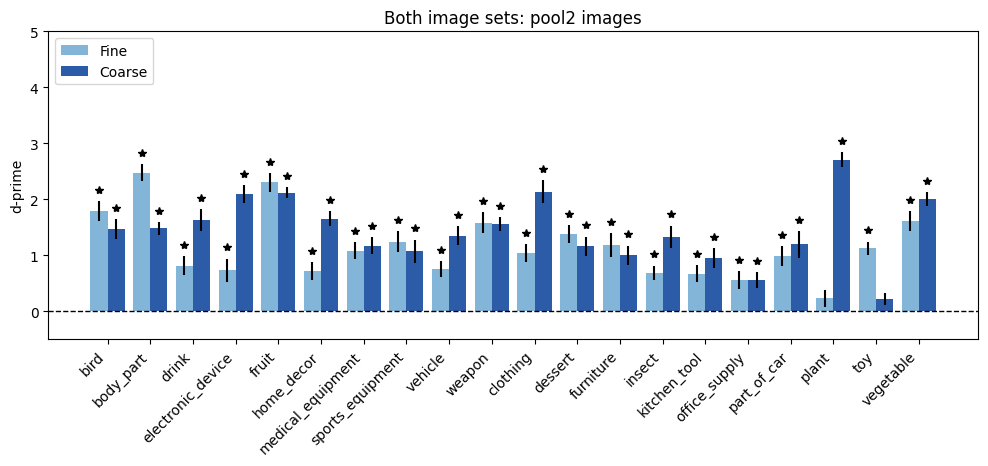

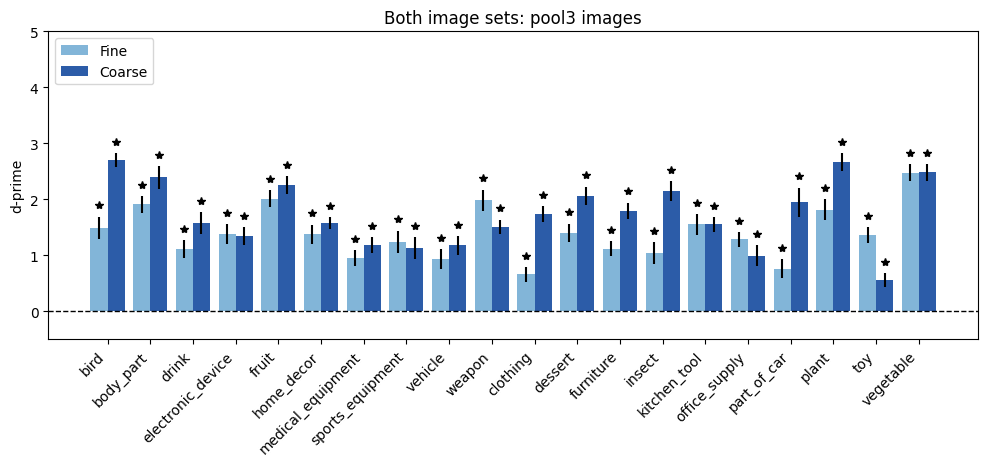

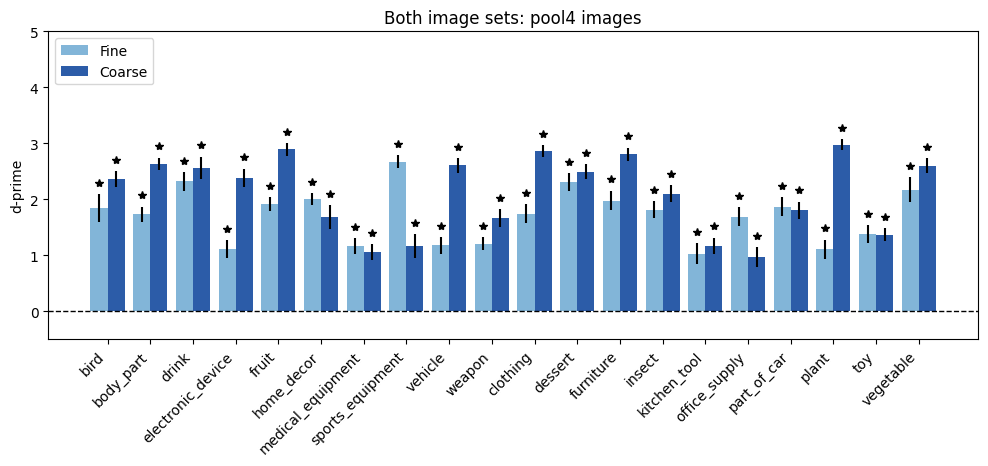

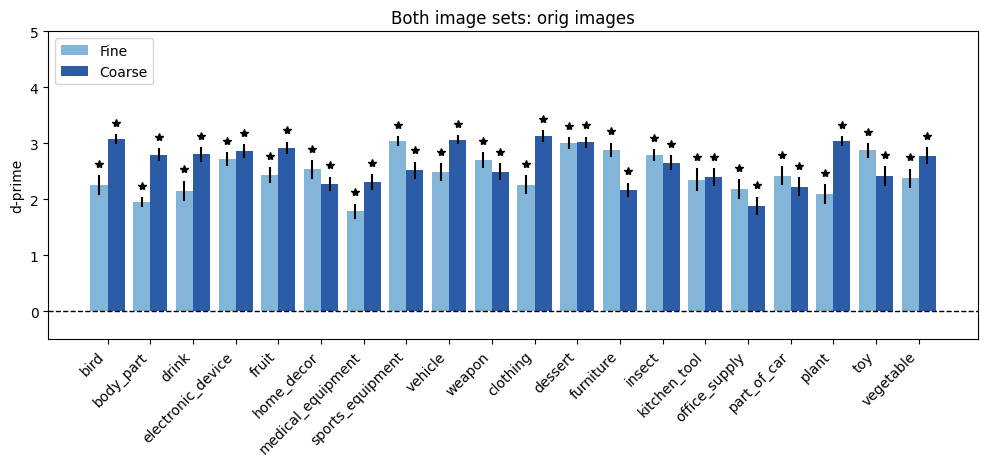

In [38]:
    
for ii in range(5):

    plt.figure(figsize=(12,4))

    ax = plt.subplot(1,1,1)

    meanvals = []; semvals = [];
    
    for cbi in range(2):
        
        vals = dprime_by_supcat[cbi]
    
        d = vals[:,:,ii,:]
        
        meanvals += [np.mean(d, axis=0)]
        semvals += [np.std(d, axis=0)/np.sqrt(d.shape[0])]
        
    meanvals = np.concatenate(meanvals,axis=1)
    semvals = np.concatenate(semvals,axis=1)
    n_super = meanvals.shape[1]
    
    lh = []
    for cc in [0,1]:

        x = np.arange(n_super)+xjitters[cc]

        h = plt.bar(x, meanvals[cc,:], color=cue_level_colors[cc,:], width=xjitters[1]*2)

        lh.append(h)

        plt.errorbar(x, meanvals[cc,:], semvals[cc,:], linestyle='none', color='k')

        # vals = d[:,cc,:]
        # t, p = scipy.stats.ttest_1samp(vals, popmean=0, alternative='greater')

        for sc in range(n_super):

            if pvals_fdr[cc,ii,sc]<0.01:
                height = meanvals[cc,sc]+semvals[cc,sc]+0.20
                plt.plot(x[sc], height, '*', color='k')

    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right');

    plt.ylabel('d-prime')

    plt.axhline(0.0, color='k',
            # color=[0.8, 0.8, 0.8],
            linestyle='--', linewidth=1)

    plt.ylim([-.5, 5.0])

    ax.legend(lh, cue_level_names, loc='upper left')


    # plt.axhline(0, color=[0.8, 0.8, 0.8])

    plt.title('Both image sets: %s images'%(image_type_names[ii]))